<a href="https://colab.research.google.com/github/shkhrkat/Kubric/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

> The objective of this task is to detect **negative reviews** in the dataset. 
> Formally, given a training sample of reviews and labels, where label ‘1’ denotes the review is **negative** and label ‘0’ denotes the tweet is **positive or neutral**.

# **Table of Contents**

1. **Dataset Preparation**: The first step is the Dataset Preparation step which includes the process of loading a dataset and performing basic pre-processing. The dataset is then splitted into train and validation sets.

2. **Feature Engineering**: The next step is the Feature Engineering in which the raw dataset is transformed into flat features which can be used in a machine learning model. This step also includes the process of creating new features from the existing data.

3. **Model Training**: The final step is the Model Building step in which a machine learning model is trained on a labelled dataset.

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import os
from bs4 import BeautifulSoup
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost, textblob, string
from tensorflow.keras.preprocessing import text, sequence

# 1. **Dataset Preparation**
>For the purpose of this project, I am the using dataset of **Amazon fine food reviews** which is avaliable on kaggle. The dataset contains around 500,000 reviews and other relevant data. But for this project we will only use 50,000 reviews due to lack of computational power

## 1.1 Get Dataset
> Dataset from kaggle can be directly imported in Google Colab

In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"keshav1805","key":"cb831913b2d58060afc3afc1e2d53e0f"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 233M/242M [00:02<00:00, 107MB/s]
100% 242M/242M [00:02<00:00, 107MB/s]


In [ ]:
!unzip amazon-fine-food-reviews.zip -d amazon-fine-food-reviews

Archive:  amazon-fine-food-reviews.zip
  inflating: amazon-fine-food-reviews/Reviews.csv  
  inflating: amazon-fine-food-reviews/database.sqlite  
  inflating: amazon-fine-food-reviews/hashes.txt  


In [ ]:
data = pd.read_csv("/content/amazon-fine-food-reviews/Reviews.csv",nrows=50000)
data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


But we don't need columns except

* Text
* Summary
* Score

In [ ]:
data.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Time'], axis = 1, inplace=True)
data.head(1)

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

## 1.2 Data Preprocessing

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


###Text Cleaning

>We will perform the below preprocessing tasks for our data:

* Convert everything to lowercase
* Remove HTML tags
* Contraction mapping
* Remove (‘s)
* Remove any text inside the parenthesis ( )
* Eliminate punctuations and special characters
* Remove stopwords
* Remove short words

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for text in data['Text']:
    cleaned_text.append(text_cleaner(text))

In [ ]:
cleaned_summary = []
for text in data['Summary']:
    cleaned_summary.append(text_cleaner(text))

In [ ]:
data['Text']=cleaned_text
data['Summary']=cleaned_summary
data['Summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data[:5]

,Score,Summary,Text
0,5,good quality dog food,bought several vitality canned dog food produc...
1,1,advertised,product arrived labeled jumbo salted peanuts p...
2,4,delight says,confection around centuries light pillowy citr...
3,2,cough medicine,looking secret ingredient robitussin believe f...
4,5,great taffy,great taffy great price wide assortment yummy ...


### Generate Target (Y)
> Raw dataset doesn't have any 0's and 1's from which we can classify a review as positive or negative. But dataset has provided the star ratings along with reviews. 

>Ratings of reviews range from 1 to 5. So, we will group reviews of rating (1,2) as **negative**, (3) as **neutral** and (4,5) as **positive**.

>That means target of a **positive** review is **[0 0 1]**, of a **neutral** is **[0 1 0]** and of a **negative** is **[1 0 0]**

In [ ]:
def generate_y(score):
  x = np.zeros(3)
  if score > 3:
    x[2] = 1
  elif score < 3:
    x[0] = 1
  else:
    x[1] = 1
  return x

In [ ]:
score = list(data['Score'])
target_y = np.zeros((len(score), 3))
count = [0]*3

for i in range(len(score)):
  if score[i] == 3:
    target_y[i,1] = 1
    count[1] += 1
  elif score[i] > 3:
    target_y[i,2] = 1
    count[2] += 1
  elif score[i] < 3: 
    target_y[i,0] = 1
    count[0] += 1
count

[6891, 3624, 35419]

In [ ]:
count[:-1]

[6891, 3624]

In [ ]:
data['Target'] = list(target_y)
data[:5]

,Score,Summary,Text,Target
0,5,good quality dog food,bought several vitality canned dog food produc...,"[0.0, 0.0, 1.0]"
1,1,advertised,product arrived labeled jumbo salted peanuts p...,"[1.0, 0.0, 0.0]"
2,4,delight says,confection around centuries light pillowy citr...,"[0.0, 0.0, 1.0]"
3,2,cough medicine,looking secret ingredient robitussin believe f...,"[1.0, 0.0, 0.0]"
4,5,great taffy,great taffy great price wide assortment yummy ...,"[0.0, 0.0, 1.0]"


### Data visualization

In [ ]:
from matplotlib import pyplot as plt

def plot(x, y, x_label, y_label, title, type = 'bo'):
  plt.plot(x, y, type)  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()   

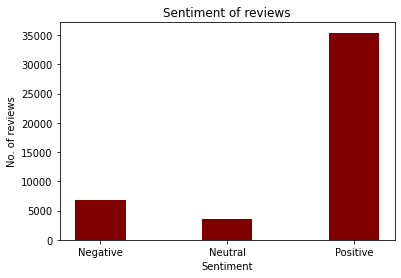

In [ ]:
plt.bar(['Negative', 'Neutral', 'Positive'], count, color ='maroon', width = 0.4) 
  
plt.xlabel("Sentiment")
plt.ylabel("No. of reviews")
plt.title("Sentiment of reviews")
plt.show() 

As from the above graph we can see the data is highly imbalanced towards Positive reviews. To solve this problem I decided to add data for negative and neutral reviews from full dataset and reduce the positive sentiment data from present dataset

In [ ]:
for i in range(data.shape[0]):
  if count[2] > 25000:
    if score[i] > 3:
      data['Text'][i] = np.nan
      count[2] -= 1
  else:
    break
count

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


[6891, 3624, 25000]

In [ ]:
data.dropna(axis=0,inplace=True)
data.shape

(36036, 4)

In [ ]:
full_dataset = pd.read_csv("/content/amazon-fine-food-reviews/Reviews.csv")

In [ ]:
add_reviews = []
for i in range(51000, full_dataset.shape[0]):
  if count[0] < 25000:
    if full_dataset['Score'][i] < 3:
      add_reviews.append([full_dataset['Score'][i], full_dataset['Summary'][i], full_dataset['Text'][i], generate_y(full_dataset['Score'][i])])
      count[0] += 1
  if count[1] < 25000:
    if full_dataset['Score'][i] == 3:
      add_reviews.append([full_dataset['Score'][i], full_dataset['Summary'][i], full_dataset['Text'][i], generate_y(full_dataset['Score'][i])])
      count[1] += 1
count

[25000, 25000, 25000]

In [ ]:
add_data = pd.DataFrame(add_reviews, columns=['Score', 'Summary', 'Text', 'Target'])
add_data[:5]

,Score,Summary,Text,Target
0,2,Old Spice,I like Dynasty Chinese Five Spice as a product...,"[1.0, 0.0, 0.0]"
1,1,Makes my dogs sick,While the ingredients look good (though the wa...,"[1.0, 0.0, 0.0]"
2,3,"decent dog food, but Fromm's is better","This brand is not bad, the ingredients are all...","[0.0, 1.0, 0.0]"
3,1,Worst Shipping EVER,"I love Weruva for my dogs, let me say that up ...","[1.0, 0.0, 0.0]"
4,1,My dog ate it and got sick,My dog ate this product packaged in Thailand a...,"[1.0, 0.0, 0.0]"


In [ ]:
cleaned_text_1 = []
cleaned_summary_1 = []
for text in add_data['Text']:
  cleaned_text_1.append(text_cleaner(text))
for summary in add_data['Summary']:
  cleaned_summary_1.append(text_cleaner(str(summary)))

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b000v9lq30/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b000eyobru/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [ ]:
add_data['Text']=cleaned_text_1
add_data['Summary']=cleaned_summary_1
add_data['Summary'].replace('', np.nan, inplace=True)
add_data.dropna(axis=0,inplace=True)

In [ ]:
add_data.shape

(38645, 4)

In [ ]:
dataset = pd.concat([data, add_data], ignore_index=True)
dataset.shape

(74681, 4)

In [ ]:
score = list(dataset['Score'])
counter = [0]*3

for i in range(len(score)):
  if score[i] == 3:
      counter[1] += 1
  elif score[i] > 3:  
    counter[2] += 1
  elif score[i] < 3: 
    counter[0] += 1
counter

[23300, 23604, 27777]

In [ ]:
sentiment = []
score = list(dataset['Score'])
for i in range(dataset.shape[0]):
  if score[i] > 3:
    sentiment.append('positive')
  elif score[i] < 3:
    sentiment.append('negative')
  else:
    sentiment.append('neutral')

In [ ]:
dataset['Sentiment'] = sentiment
dataset[:5]

,Score,Summary,Text,Target,Sentiment
0,1,advertised,product arrived labeled jumbo salted peanuts p...,"[1.0, 0.0, 0.0]",negative
1,2,cough medicine,looking secret ingredient robitussin believe f...,"[1.0, 0.0, 0.0]",negative
2,1,cats fans new food,cats happily eating felidae platinum two years...,"[1.0, 0.0, 0.0]",negative
3,2,poor taste,love eating good watching looking movies sweet...,"[1.0, 0.0, 0.0]",negative
4,1,nasty flavor,candy red flavor plan chewy would never buy,"[1.0, 0.0, 0.0]",negative


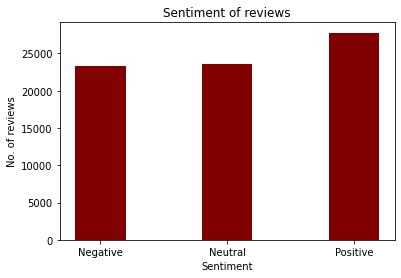

In [ ]:
plt.bar(['Negative', 'Neutral', 'Positive'], counter, color ='maroon', width = 0.4) 
  
plt.xlabel("Sentiment")
plt.ylabel("No. of reviews")
plt.title("Sentiment of reviews")
plt.show() 

Now dataset is much more balanced

## 1.3 Split Dataset

In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(dataset['Text'], dataset['Sentiment'], test_size = 0.2)

In [ ]:
train_x[:5]

37889    use cheese sauce mixes mostly topping steamed ...
5180     taco bell chipotle sauce much better ranchero ...
31594    product information tell tea includes processe...
18701    bought treats year olo husky beagle mix dog wi...
34206    buy often always satisfied dog loves keep teet...
Name: Text, dtype: object

In [ ]:
# label encode the target variable 
label_encoder = preprocessing.LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
valid_y = label_encoder.fit_transform(valid_y)

In [ ]:
train_y[:5]

array([1, 1, 0, 2, 2])

#2. **Feature Extraction**
>The next step is the feature extraction step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. 

>* Count Vectors as features
* TF-IDF Vectors as features
  1. Word level
  2. N-Gram level
  3. Character level
* Word Embeddings as features
*  Text / NLP based features
*  Topic Models as features


## 2.1 Count Vectors as features

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(dataset['Text'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

## 2.2 TF-IDF Vectors as features

In [ ]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(dataset['Text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(dataset['Text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(dataset['Text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## 2.3 Word Embeddings

I have used GloVe embeddings as pretrained embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir wiki-news-300d-1M
!unzip /content/drive/MyDrive/ML_resources/wiki-news-300d-1M.vec.zip -d wiki-news-300d-1M

Archive:  /content/drive/MyDrive/ML_resources/wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M/wiki-news-300d-1M.vec  


In [ ]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

In [ ]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(dataset['Text'])
word_index = token.word_index
word_index

{'like': 1,
 'would': 2,
 'taste': 3,
 'good': 4,
 'one': 5,
 'product': 6,
 'coffee': 7,
 'flavor': 8,
 'tea': 9,
 'food': 10,
 'great': 11,
 'get': 12,
 'really': 13,
 'much': 14,
 'love': 15,
 'buy': 16,
 'time': 17,
 'little': 18,
 'dog': 19,
 'amazon': 20,
 'also': 21,
 'even': 22,
 'better': 23,
 'use': 24,
 'tried': 25,
 'try': 26,
 'first': 27,
 'chocolate': 28,
 'eat': 29,
 'price': 30,
 'make': 31,
 'could': 32,
 'well': 33,
 'find': 34,
 'water': 35,
 'cup': 36,
 'box': 37,
 'bag': 38,
 'think': 39,
 'sugar': 40,
 'bought': 41,
 'made': 42,
 'drink': 43,
 'two': 44,
 'used': 45,
 'best': 46,
 'still': 47,
 'way': 48,
 'sweet': 49,
 'bad': 50,
 'found': 51,
 'tastes': 52,
 'know': 53,
 'got': 54,
 'something': 55,
 'however': 56,
 'bit': 57,
 'give': 58,
 'since': 59,
 'cannot': 60,
 'order': 61,
 'dogs': 62,
 'thought': 63,
 'want': 64,
 'free': 65,
 'ingredients': 66,
 'day': 67,
 'store': 68,
 'never': 69,
 'treats': 70,
 'back': 71,
 'say': 72,
 'brand': 73,
 'many': 74,


In [ ]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=80)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=80)

In [ ]:
5# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 3. **Model Building**
>The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model.
* Naive Bayes Classifier
* Linear Classifier / Logistic Regression
* Support Vector Machine
* Random Forest Classifier
* Boosting Model
* Shallow Neural Networks
* Deep Neural Networks
  1. Convolutional Neural Network (CNN)
  2.Long Short Term Modelr (LSTM)
  3.Gated Recurrent Unit (GRU)
  4.Bidirectional RNN
  5.Recurrent Convolutional Neural Network (RCNN)

>The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.



In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

## 3.1 Naive Bayes Classifier

In [ ]:
# Naive Bayes on Count Vectors
accuracy_NB = [0]*4
accuracy_NB[0] = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("Naive Bayes, Count Vectors:", round(accuracy_NB[0]*100,2), '%')

Naive Bayes, Count Vectors: 68.94 %


In [ ]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy_NB[1] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("Naive Bayes, WordLevel TF-IDF:", round(accuracy_NB[1]*100,2), '%')

Naive Bayes, WordLevel TF-IDF: 68.0 %


In [ ]:
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy_NB[2] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Naive Bayes, N-gram TF-IDF:", round(accuracy_NB[2]*100,2), '%')

Naive Bayes, N-gram TF-IDF: 62.79 %


In [ ]:
# Naive Bayes on Character Level TF IDF Vectors
accuracy_NB[3] = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Naive Bayes, CharLevel vector:", round(accuracy_NB[3]*100,2), '%')

Naive Bayes, CharLevel vector: 64.11 %


In [ ]:
accuracy_NB = [round(i*100,2) for i in accuracy_NB]

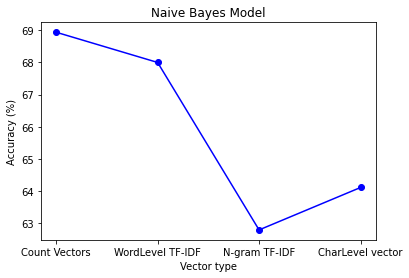

In [ ]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_NB, 'Vector type', 'Accuracy (%)', 'Naive Bayes Model','-bo')

So, from above analysis we can say that Naive bayes performs best with Count vectors

## 3.2 Linear Classifier/ Logistic Regression

In [ ]:
accuracy_LR = [0]*4

# Linear Classifier on Count Vectors
accuracy_LR[0] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_count, train_y, xvalid_count)
print("Logistic Regression, Count Vectors:", round(accuracy_LR[0]*100,2), '%')

Logistic Regression, Count Vectors: 73.22 %


In [ ]:
# Linear Classifier on Word Level TF IDF Vectors
accuracy_LR[1] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf, train_y, xvalid_tfidf)
print("Logistic Regression, WordLevel TF-IDF:", round(accuracy_LR[1]*100,2), '%')

Logistic Regression, WordLevel TF-IDF: 72.07 %


In [ ]:
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy_LR[2] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Logistic Regression, N-Gram Vectors:", round(accuracy_LR[2]*100,2), '%')


Logistic Regression, N-Gram Vectors: 63.04 %


In [ ]:
# Linear Classifier on Character Level TF IDF Vectors
accuracy_LR[3] = train_model(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Logistic Regression, CharLevel Vectors:", round(accuracy_LR[3]*100,2), '%')

Logistic Regression, CharLevel Vectors: 69.12 %


In [ ]:
accuracy_LR = [round(i*100,2) for i in accuracy_LR]

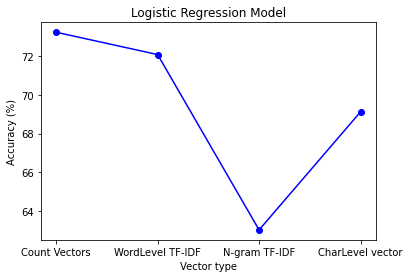

In [ ]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_LR, 'Vector type', 'Accuracy (%)', 'Logistic Regression Model','-bo')

##3.3 Support Vector Machine (SVM)

In [ ]:
accuracy_SVM = [0]*4

# SVM on Count vectors
accuracy_SVM[0] = train_model(svm.LinearSVC(max_iter=20000), xtrain_count, train_y, xvalid_count)
print("SVM, Count Vectors:", round(accuracy_SVM[0]*100,2), '%')

SVM, Count Vectors: 72.08 %


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# SVM on Word Level TF IDF Vectors
accuracy_SVM[1] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf, train_y, xvalid_tfidf)
print("SVM, WordLevel TF-IDF:", round(accuracy_SVM[1]*100,2), '%')

SVM, WordLevel TF-IDF: 71.25 %


In [ ]:
# SVM on Ngram Level TF IDF Vectors
accuracy_SVM[2] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("SVM, N-Gram Vectors: ", round(accuracy_SVM[2]*100,2), '%')

SVM, N-Gram Vectors:  62.66 %


In [ ]:
# SVM on Character Level TF IDF Vectors
accuracy_SVM[3] = train_model(svm.LinearSVC(max_iter=20000), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Logistic Regression, CharLevel Vectors:", round(accuracy_SVM[3]*100,2), '%')

Logistic Regression, CharLevel Vectors: 69.34 %


In [ ]:
accuracy_SVM = [round(i*100,2) for i in accuracy_SVM]
accuracy_SVM

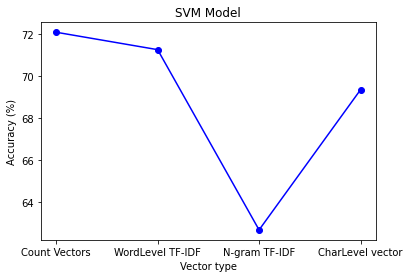

In [ ]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_SVM, 'Vector type', 'Accuracy (%)', 'SVM Model','-bo')

## 3.4 Random Forest Classifier

In [ ]:
accuracy_RF = [0]*4

In [ ]:
# RF on Count Vectors
accuracy_RF[0] = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("Random Forest, Count Vectors:", round(accuracy_RF[0]*100,2), '%')

Random Forest, Count Vectors: 73.87 %


In [ ]:
# RF on Word Level TF IDF Vectors
accuracy_RF[1] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("Random Forest, WordLevel TF-IDF:", round(accuracy_RF[1]*100,2), '%')

Random Forest, WordLevel TF-IDF: 73.27 %


In [ ]:
# RF on N-gram Vectors
accuracy_RF[2] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("Random Forest, N-Gram Vectors:", round(accuracy_RF[2]*100, 2), '%')

Random Forest, N-Gram Vectors: 65.47 %


In [ ]:
# RF on Character Level TF IDF Vectors
accuracy_RF[3] = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("Random Forest, N-Gram Vectors:", round(accuracy_RF[3]*100, 2), '%')
accuracy_RF[3] = accuracy_RF[3]*100

Random Forest, N-Gram Vectors: 69.18 %


In [ ]:
accuracy_RF = [round(i*100,2) for i in accuracy_RF]
accuracy_RF

[73.87, 73.27, 65.47, 65.42]

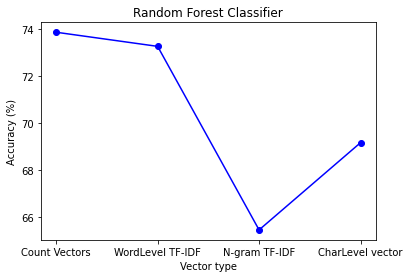

In [ ]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_RF, 'Vector type', 'Accuracy (%)', 'Random Forest Classifier','-bo')

## 3.5 Boosting Model (XgBoost)

In [ ]:
accuracy_XGB = [0]*4

In [ ]:
# Extereme Gradient Boosting on Count Vectors
accuracy_XGB[0] = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors:", round(accuracy_XGB[0]*100,2), '%')

Xgb, Count Vectors: 62.56 %


In [ ]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy_XGB[1] = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF:", round(accuracy_XGB[1]*100,2),'%')

Xgb, WordLevel TF-IDF: 62.69 %


In [ ]:
# Extereme Gradient Boosting on N-gram TF IDF Vectors
accuracy_XGB[2] = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print('Xgb, N-gram TF-IDF vector:', round(accuracy_XGB[2]*100,2),'%')

Xgb, N-gram TF-IDF vector: 63.2 %


In [ ]:
# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy_XGB[3] = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print('Xgb, Character vector TF-IDF vector:', round(accuracy_XGB[3]*100,2),'%')

Xgb, Character vector TF-IDF vector: 63.2 %


In [ ]:
accuracy_XGB = [round(i*100,2) for i in accuracy_XGB]
accuracy_XGB

[62.56, 62.69, 63.2, 63.2]

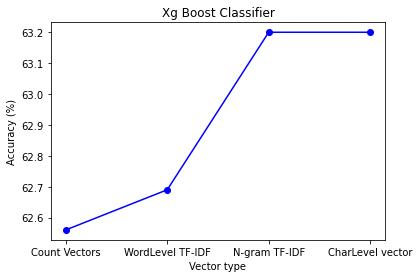

In [ ]:
plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'],accuracy_XGB, 'Vector type', 'Accuracy (%)', 'Xg Boost Classifier','-bo')

Let's compare all the models

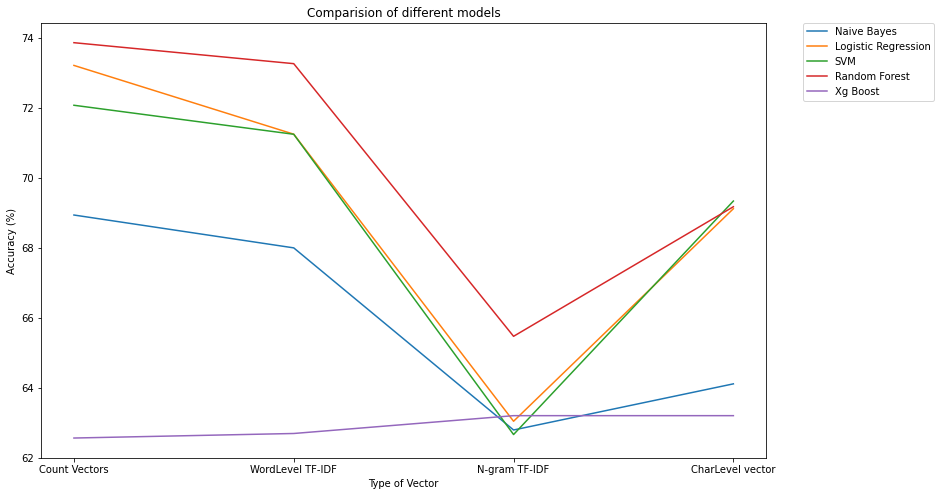

In [ ]:
plt.figure(figsize=[13, 8])
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_NB, label = 'Naive Bayes')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_LR, label = 'Logistic Regression')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_SVM, label = 'SVM')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_RF, label = 'Random Forest')
plt.plot(['Count Vectors', 'WordLevel TF-IDF', 'N-gram TF-IDF', 'CharLevel vector'], accuracy_XGB, label = 'Xg Boost')
plt.title('Comparision of different models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Type of Vector')
plt.ylabel('Accuracy (%)')
plt.show()

## 3.6 Shallow Neural Networks

In [ ]:
from tensorflow.keras import layers, models, optimizers
from tensorflow import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation
from tensorflow.keras.layers import Input, Flatten, Embedding, LSTM, Dropout, Dense, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X = list(dataset['Text'])
Y = LabelBinarizer().fit_transform(dataset.Sentiment)

In [ ]:
x = 1
dataset['Sentiment'][x], Y[x]

('negative', array([1, 0, 0]))

In [ ]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(X, Y, test_size = 0.2)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['Text'])

In [ ]:
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 80

In [ ]:
train_x = pad_sequences(train_x, padding='post', maxlen=maxlen, truncating='post')
test_x = pad_sequences(test_x, padding='post', maxlen=maxlen, truncating='post')

In [ ]:
train_x[0]

array([ 11,   6,  46,  40,  65,  28, 436, 146,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [ ]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = []
scores = []
loss_type = 'binary_crossentropy'
accuracy_type = 'categorical_accuracy'

In [ ]:
def print_model_architecture(model, name):
  plot_model(model, to_file=name+'.png', show_shapes=True, show_layer_names=True)
  display(Image(filename=name+'.png'))

In [ ]:
def get_score(model):
  score = model.evaluate(test_x, test_y, verbose=1)

  

  print("Test Score:", score[0])
  print("Test Accuracy:", score[1])
  return score

In [ ]:
def plot_results(history):
  plt.plot(history.history[accuracy_type])
  plt.plot(history.history['val_'+accuracy_type])

  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train','test'], loc='upper left')
  plt.show()

In [ ]:
def shallow_NN(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(128, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(3, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
    
    return classifier

In [ ]:
shallow_NN = shallow_NN(maxlen)

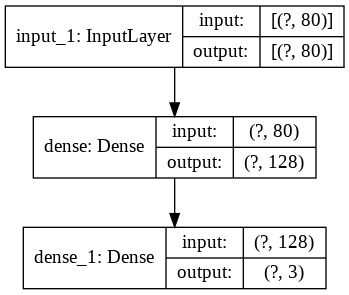

In [ ]:
print_model_architecture(shallow_NN, 'shallow_NN')

In [ ]:
history_shallow = shallow_NN.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_shallow)

Epoch 1/10
1494/1494 [==============================] - 4s 3ms/step - loss: 116.6402 - categorical_accuracy: 0.3435 - val_loss: 35.4892 - val_categorical_accuracy: 0.3510
Epoch 2/10
1494/1494 [==============================] - 4s 3ms/step - loss: 16.2210 - categorical_accuracy: 0.3569 - val_loss: 6.1315 - val_categorical_accuracy: 0.3511
Epoch 3/10
1494/1494 [==============================] - 4s 3ms/step - loss: 4.4893 - categorical_accuracy: 0.3427 - val_loss: 3.3334 - val_categorical_accuracy: 0.3351
Epoch 4/10
1494/1494 [==============================] - 4s 3ms/step - loss: 2.3895 - categorical_accuracy: 0.3488 - val_loss: 1.6071 - val_categorical_accuracy: 0.3671
Epoch 5/10
1494/1494 [==============================] - 4s 3ms/step - loss: 1.1569 - categorical_accuracy: 0.3527 - val_loss: 0.8425 - val_categorical_accuracy: 0.3676
Epoch 6/10
1494/1494 [==============================] - 4s 3ms/step - loss: 0.7555 - categorical_accuracy: 0.3642 - val_loss: 0.7077 - val_categorical_accur

In [ ]:
scores.append(get_score(shallow_NN))

467/467 [==============================] - 1s 2ms/step - loss: 0.6561 - categorical_accuracy: 0.3687
Test Score: 0.6560524702072144
Test Accuracy: 0.36868178844451904


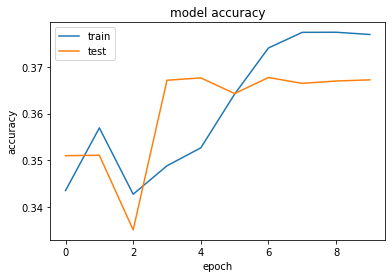

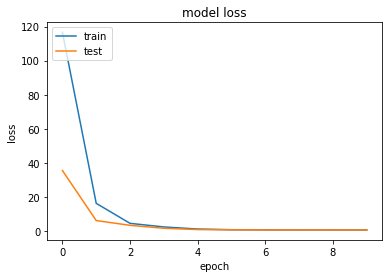

In [ ]:
plot_results(history[0])

## 3.7 Deep Neural Networks

### 3.7.1 Convolutional Neural Network

In [ ]:
def cnn(input_length, prior = True):
    # Add an Input Layer
    input_layer = layers.Input((input_length, ))

    # Add the word embedding Layer
    if prior:
      embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
    else:
      embedding_layer = layers.Embedding(vocab_size, 300, trainable=True)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(128, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(64, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
    
    return model


Without Prior 

In [ ]:
cnn_classifier_without_prior = cnn(maxlen, False)

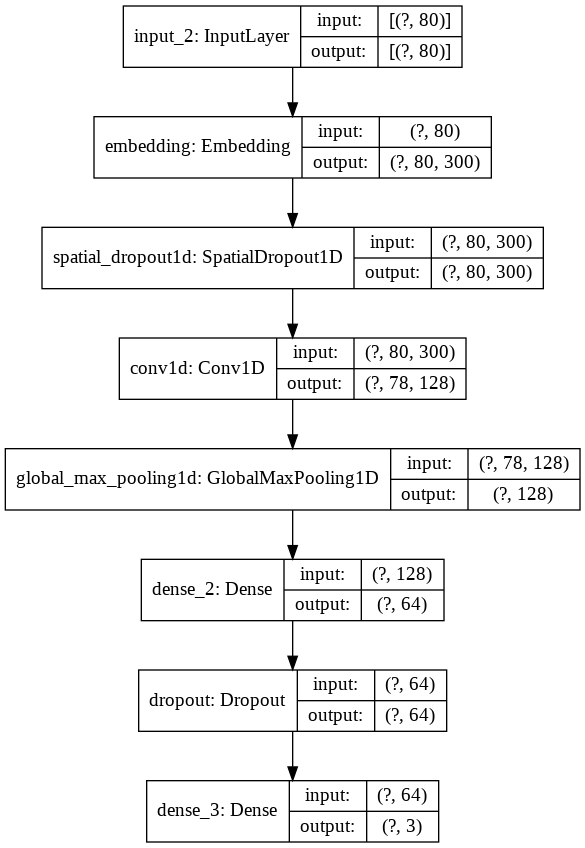

In [ ]:
print_model_architecture(cnn_classifier_without_prior, 'cnn_classifier_1')

In [ ]:
history_cnn_1 = cnn_classifier_without_prior.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_cnn_1)

Epoch 1/10
1494/1494 [==============================] - 209s 140ms/step - loss: 0.4664 - categorical_accuracy: 0.6482 - val_loss: 0.4147 - val_categorical_accuracy: 0.7056
Epoch 2/10
1494/1494 [==============================] - 207s 138ms/step - loss: 0.3221 - categorical_accuracy: 0.7918 - val_loss: 0.3890 - val_categorical_accuracy: 0.7309
Epoch 3/10
1494/1494 [==============================] - 202s 135ms/step - loss: 0.2031 - categorical_accuracy: 0.8802 - val_loss: 0.4375 - val_categorical_accuracy: 0.7217


In [ ]:
scores.append(get_score(cnn_classifier_without_prior))

467/467 [==============================] - 1s 3ms/step - loss: 0.4490 - categorical_accuracy: 0.7123
Test Score: 0.44897329807281494
Test Accuracy: 0.7123250961303711


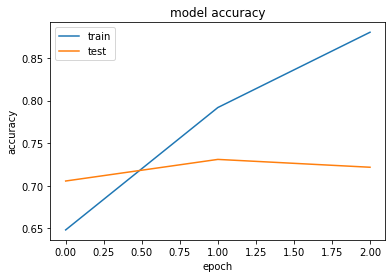

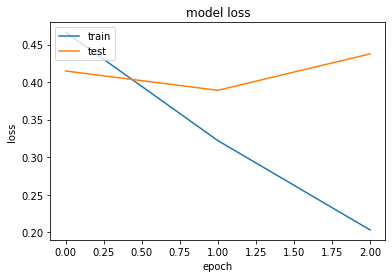

In [ ]:
plot_results(history[1])

With Prior of embedding matrix

In [ ]:
cnn_classifier_with_prior = cnn(maxlen)

In [ ]:
history_cnn_2 = cnn_classifier_with_prior.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_cnn_2)

Epoch 1/10
1494/1494 [==============================] - 203s 136ms/step - loss: 0.4641 - categorical_accuracy: 0.6487 - val_loss: 0.3953 - val_categorical_accuracy: 0.7220
Epoch 2/10
1494/1494 [==============================] - 199s 134ms/step - loss: 0.3362 - categorical_accuracy: 0.7770 - val_loss: 0.3855 - val_categorical_accuracy: 0.7321
Epoch 3/10
1494/1494 [==============================] - 200s 134ms/step - loss: 0.2288 - categorical_accuracy: 0.8605 - val_loss: 0.4183 - val_categorical_accuracy: 0.7429


In [ ]:
scores.append(get_score(cnn_classifier_with_prior))

467/467 [==============================] - 1s 3ms/step - loss: 0.4266 - categorical_accuracy: 0.7370
Test Score: 0.4266324043273926
Test Accuracy: 0.7369619011878967


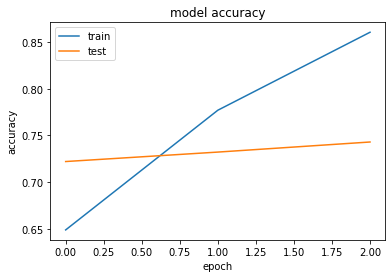

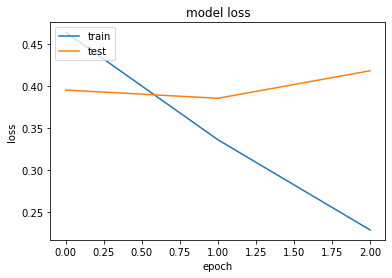

In [ ]:
plot_results(history[2])

### 3.7.2 Recurrent Neural Network – LSTM

In [ ]:
def rnn_lstm(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the LSTM Layer
  lstm_layer = layers.LSTM(128)(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model


In [ ]:
rnn_lstm_classifier = rnn_lstm(maxlen)

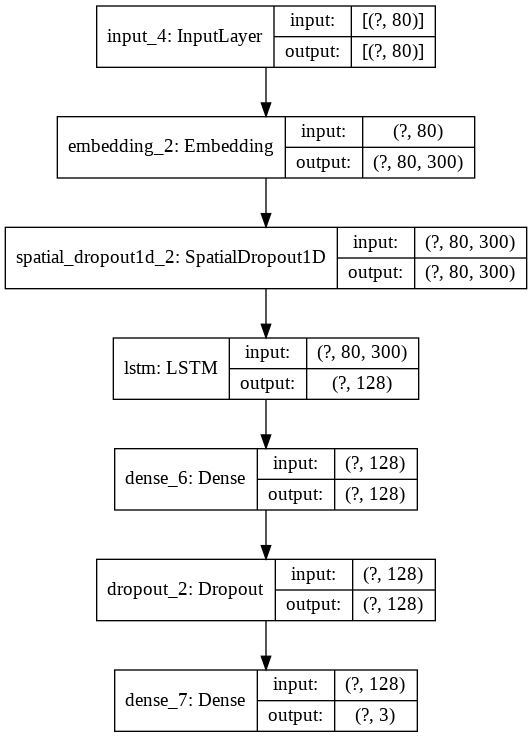

In [ ]:
print_model_architecture(rnn_lstm_classifier, 'rnn_lstm_classifier')

In [ ]:
history_rnn_lstm = rnn_lstm_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rnn_lstm)

Epoch 1/10
1494/1494 [==============================] - 209s 140ms/step - loss: 0.6306 - categorical_accuracy: 0.4020 - val_loss: 0.6074 - val_categorical_accuracy: 0.5065
Epoch 2/10
1494/1494 [==============================] - 210s 141ms/step - loss: 0.4482 - categorical_accuracy: 0.6741 - val_loss: 0.3958 - val_categorical_accuracy: 0.7217
Epoch 3/10
1494/1494 [==============================] - 207s 139ms/step - loss: 0.3232 - categorical_accuracy: 0.7885 - val_loss: 0.4167 - val_categorical_accuracy: 0.7350


In [ ]:
scores.append(get_score(rnn_lstm_classifier))

467/467 [==============================] - 2s 4ms/step - loss: 0.4201 - categorical_accuracy: 0.7277
Test Score: 0.42008018493652344
Test Accuracy: 0.7277231216430664


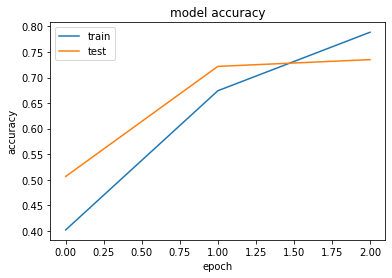

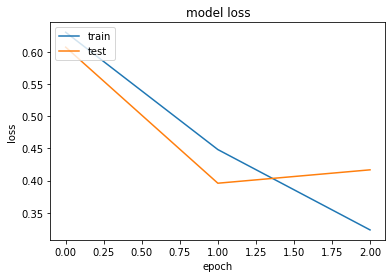

In [ ]:
plot_results(history[3])

### 3.7.3 Recurrent Neural Network – GRU

In [ ]:
def rnn_gru(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the GRU Layer
  lstm_layer = layers.GRU(128)(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model

In [ ]:
rnn_gru_classifier = rnn_gru(maxlen)

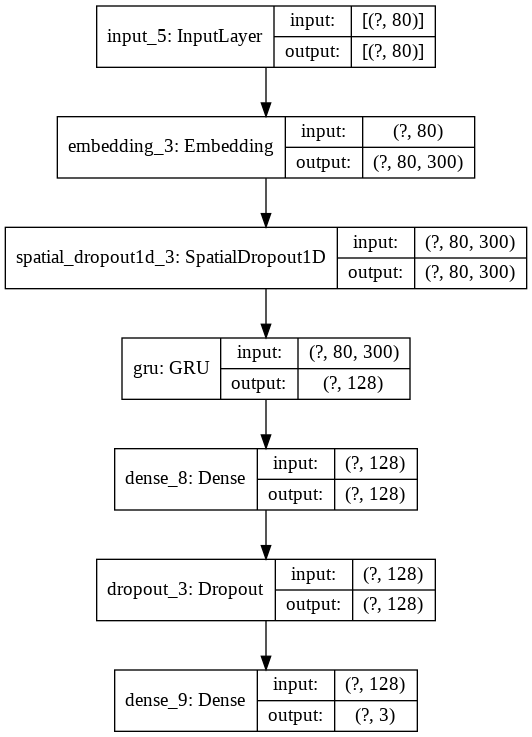

In [ ]:
print_model_architecture(rnn_gru_classifier, 'rnn_gru_classifier')

In [ ]:
history_rnn_gru = rnn_gru_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rnn_gru)

Epoch 1/10
1494/1494 [==============================] - 208s 140ms/step - loss: 0.6263 - categorical_accuracy: 0.4039 - val_loss: 0.4717 - val_categorical_accuracy: 0.6487
Epoch 2/10
1494/1494 [==============================] - 208s 139ms/step - loss: 0.4041 - categorical_accuracy: 0.7143 - val_loss: 0.3839 - val_categorical_accuracy: 0.7374
Epoch 3/10
1494/1494 [==============================] - 210s 141ms/step - loss: 0.2848 - categorical_accuracy: 0.8173 - val_loss: 0.4000 - val_categorical_accuracy: 0.7357


In [ ]:
scores.append(get_score(rnn_gru_classifier))

467/467 [==============================] - 2s 4ms/step - loss: 0.3996 - categorical_accuracy: 0.7335
Test Score: 0.39956218004226685
Test Accuracy: 0.7334806323051453


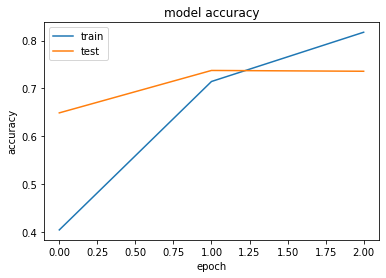

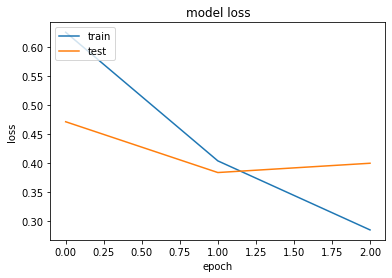

In [ ]:
plot_results(history[4])

###3.7.4 Bidirectional RNN

In [ ]:
def bidirectional_rnn(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

  # Add the LSTM Layer
  lstm_layer = layers.Bidirectional(layers.GRU(128))(embedding_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics=[accuracy_type])
  
  return model


In [ ]:
bidirectional_rnn_classifier = bidirectional_rnn(maxlen)

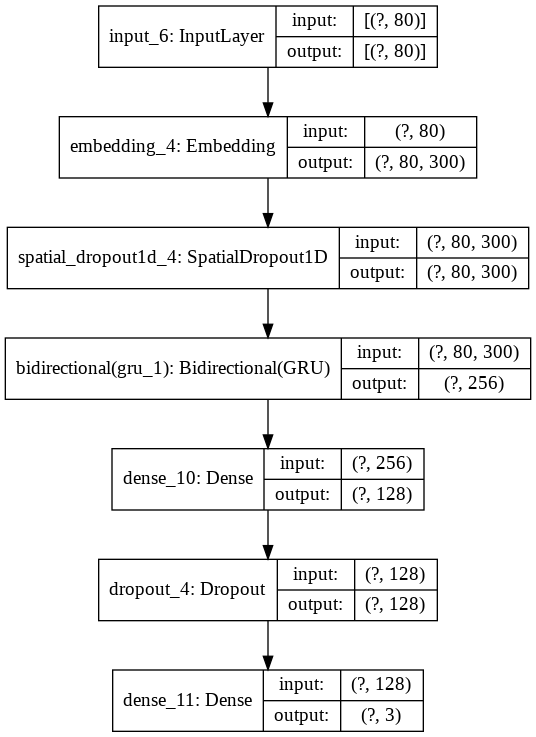

In [ ]:
print_model_architecture(bidirectional_rnn_classifier, 'bidirectional_rnn_classifier')

In [ ]:
history_bidirectional_rnn = bidirectional_rnn_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_bidirectional_rnn)

Epoch 1/10
1494/1494 [==============================] - 218s 146ms/step - loss: 0.4504 - categorical_accuracy: 0.6578 - val_loss: 0.3883 - val_categorical_accuracy: 0.7281
Epoch 2/10
1494/1494 [==============================] - 214s 143ms/step - loss: 0.3223 - categorical_accuracy: 0.7881 - val_loss: 0.3827 - val_categorical_accuracy: 0.7405
Epoch 3/10
1494/1494 [==============================] - 214s 143ms/step - loss: 0.2242 - categorical_accuracy: 0.8626 - val_loss: 0.4251 - val_categorical_accuracy: 0.7356


In [ ]:
scores.append(get_score(bidirectional_rnn_classifier))

467/467 [==============================] - 3s 6ms/step - loss: 0.4365 - categorical_accuracy: 0.7271
Test Score: 0.4365091919898987
Test Accuracy: 0.7270536422729492


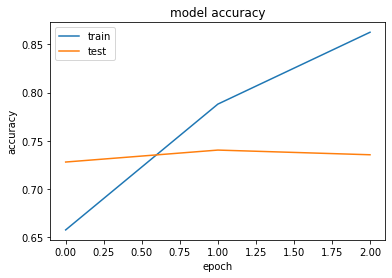

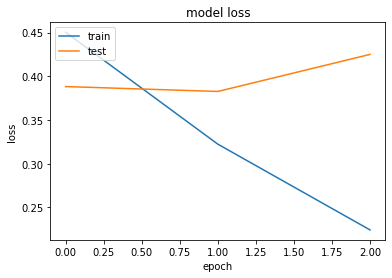

In [ ]:
plot_results(history[5])

### 3.7.5 Recurrent Convolutional Neural Network

In [ ]:
def rcnn(input_length):
  # Add an Input Layer
  input_layer = layers.Input((input_length, ))

  # Add the word embedding Layer
  embedding_layer = layers.Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=True)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
  
  # Add the recurrent layer
  rnn_layer = layers.Bidirectional(layers.GRU(128, return_sequences=True))(embedding_layer)
  
  # Add the convolutional Layer
  conv_layer = layers.Convolution1D(128, 3, activation="relu")(embedding_layer)

  # Add the pooling Layer
  pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

  # Add the output Layers
  output_layer1 = layers.Dense(128, activation="relu")(pooling_layer)
  output_layer1 = layers.Dropout(0.25)(output_layer1)
  output_layer2 = layers.Dense(3, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss=loss_type, metrics = [accuracy_type])
  
  return model


In [ ]:
rcnn_classifier = rcnn(maxlen)

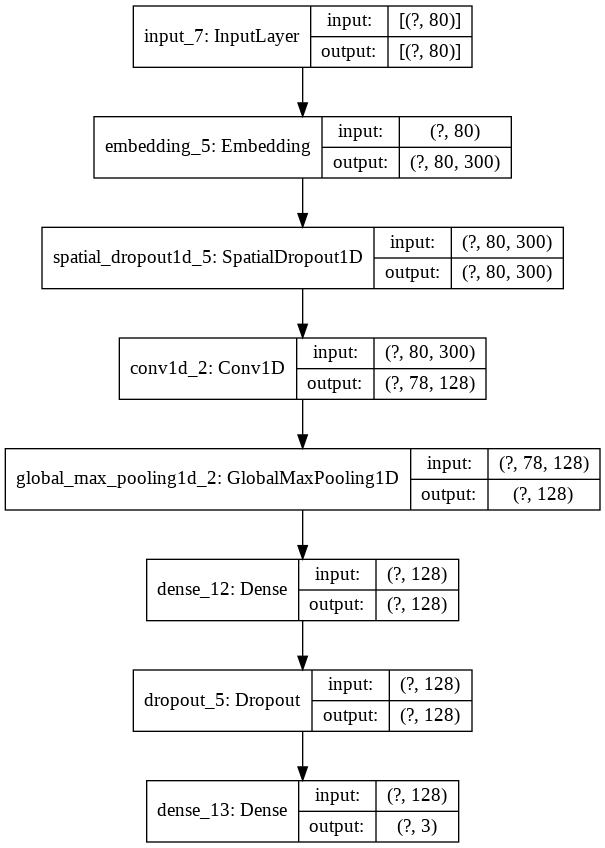

In [ ]:
print_model_architecture(rcnn_classifier, 'rcnn_classifier')

In [ ]:
history_rcnn = rcnn_classifier.fit(train_x, train_y, epochs=10, verbose=1, validation_split=0.2, callbacks=[es])
history.append(history_rcnn)

Epoch 1/10
1494/1494 [==============================] - 204s 136ms/step - loss: 0.4571 - categorical_accuracy: 0.6577 - val_loss: 0.3972 - val_categorical_accuracy: 0.7153
Epoch 2/10
1494/1494 [==============================] - 201s 135ms/step - loss: 0.3258 - categorical_accuracy: 0.7839 - val_loss: 0.3757 - val_categorical_accuracy: 0.7440
Epoch 3/10
1494/1494 [==============================] - 200s 134ms/step - loss: 0.2181 - categorical_accuracy: 0.8666 - val_loss: 0.4096 - val_categorical_accuracy: 0.7474


In [ ]:
scores.append(get_score(rcnn_classifier))

467/467 [==============================] - 1s 3ms/step - loss: 0.4180 - categorical_accuracy: 0.7355
Test Score: 0.41797828674316406
Test Accuracy: 0.7354890704154968


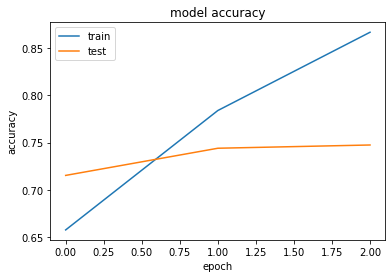

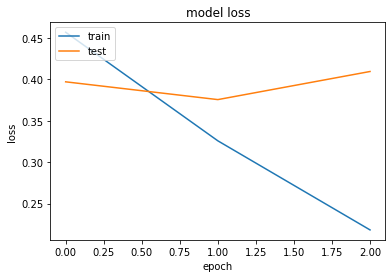

In [ ]:
plot_results(history[6])

## Let's have a comparative analysis of all the Neural networks

In [ ]:
test_accuracy = [round(i[1]*100,2) for i in scores]

In [ ]:
model_list = ['Shallow NN', 'CNN (without prior)', 'CNN (with prior)', 'RNN - LSTM', 'RNN - GRU', 'Bidirectional RNN', 'RCNN']

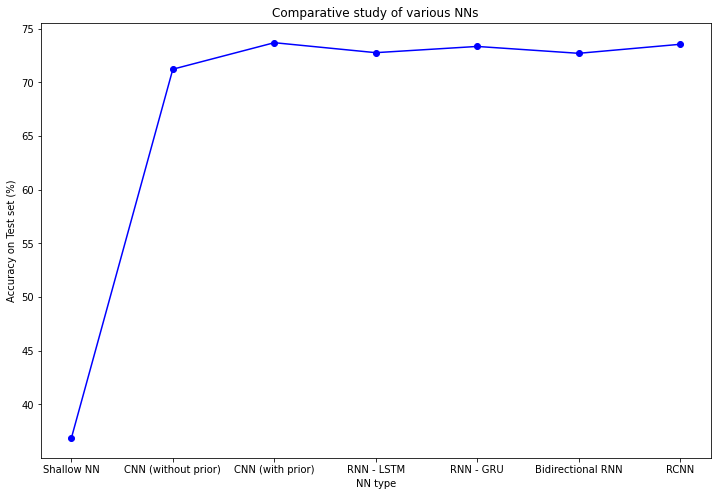

In [ ]:
plt.figure(figsize=[12,8])
plt.plot(model_list, test_accuracy, '-bo')
plt.xlabel('NN type')
plt.ylabel('Accuracy on Test set (%)')
plt.title('Comparative study of various NNs')
plt.show()